## 정상성 검정 및 확인

### 정상성이란? 

- 정상성은 추세와 계절성을 갖지 않는 진동하는 데이터이다. 
- 주기성 행동을 가지고 있지만 주기가 특정 패턴을 갖지 않고 시계열을 관측하는 어떠한 시점에서도 똑같은 모양일 것이다..
- 그러므로 추세나 계절성이 없는 데이터 == > ARIMA 모형을 적용하기 위한 조건 
- 정상성을 띄지 않는다면 정상성(stationary)을 갖춘 형태로 변경해줘야 한다. 

### 정상성 검정

Augmented Dickey-Fuller Test

- 정상성을 알아보기 위한 단위근 검정 방법
- 귀무가설 : 데이터가 정상성(stationary)을 갖지 않는다.(중요) (변동이 있다.)
- 대립가설 : 데이터가 정상성(stationary)을 갖는다 


> adfuller(x, maxlag, regression, autolag)

* x: 시계열 자료<br>
* regression: 검정에 사용할 모형 <br> &emsp; &emsp; &emsp; &emsp; {'nc': 추세 없음, 'c':상수항만 사용, 'ct':상수항&1차 추세, 'ctt':상수항&2차 추세}

* autolag: 검정 AR 모형의 차수를 자동 결정하는 알고리즘  <br> &emsp; &emsp; &emsp; &emsp; {'AIC', 'BIC', 't-stat', None}

<br>

return 값 : <br>
-         0. 검정통계량
        1. p-value
        2. 사용된 시차의 수
        3. 분석에 사용한 자료 수
        4. 1%, 5%, 10% 수준에 해당되는 검정통계량 값

In [1]:
import pandas as pd

data = pd.read_csv('../data/arima_data.csv', names = ['day', 'price'])
data.head(3)

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [3]:
data['day'] = pd.to_datetime(data['day'],format="%Y-%m-%d")
data.set_index('day', inplace=True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


In [4]:
train_len = int(len(data) * 0.8)
training = data[:train_len]
test = data.drop(training.index)

In [5]:
## 귀무가설 : 데이터가 정상성(stationary)을 갖지 않는다. (변동이 있다.)
## 대립가설 : 데이터가 정상성(stationary)을 갖는다 

from statsmodels.tsa.stattools import adfuller

adf = adfuller(training, regression='ct')

print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -1.9997199341327796
p-value : 0.6015863303794179


단위근 검정에서 p-value가 0.05보다 크므로 정상성을 갖지 않는 것으로 판단됨 

<b>차분 후 단위근 검정 재실시</b>

차분 : 비정상성을 정상성으로 만들기 위해, 관측값들의 차이를 계산하는 것

<br>

### 시계열 데이터 정상성 만족시키기

데이터 프레임을 n차 차분하고 acf, pacf를 다시 구함

> DF.diff(periods=차분횟수).iloc[1:]

alpha : 신뢰구간 (파란색 구간의 폭으로 나타남)<br>
lags : 그래프의 X축 범위

<AxesSubplot:xlabel='day'>

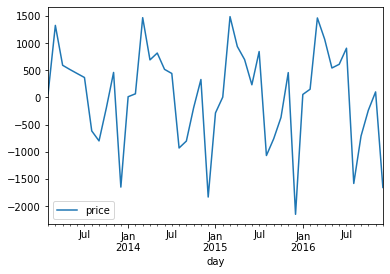

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = training.diff(1)
diff_data = diff_data.dropna()

diff_data.plot()


In [7]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(diff_data)

print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -12.094547576926441
p-value : 2.085160639960858e-22


<br>

### [Plot] ARIMA(p,d,q)의 파라미터 정하기

ACF plot와 PACF plot을 통해 AR 및 MA의 모수를 추정함
- ACF: Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF: k 이외의 모든 다른 시점 관측치의 영향력을 배제한 후의 두 관측치의 관련성을 측정하는 함수

<br>


|요약 : AR/MA 모형과 ACF/PCAF 관계 ||  |
|------|---|---|
||  AR(p)  |  MA(q) |
|ACF |점차적으로 감소| 시차q 이후에 0   |
|PACF |시차 p 이후에 0 | 점차적으로 감소 |

      

C:\Users\jjang\anaconda3\envs\ADP_Class\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


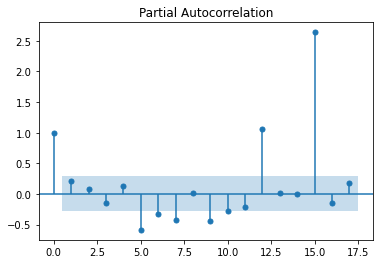

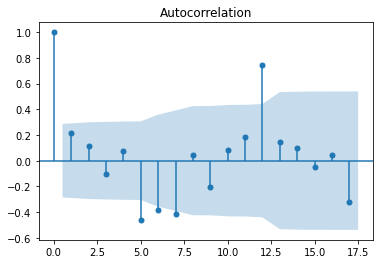

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np 
import matplotlib.pyplot as plt

plot_pacf(diff_data) #AR(p)의 값 확인 가능 ==2 

plot_acf(diff_data) #MA(q)의 값 확인 가능 == 2

plt.show()

acf 와  pacf 모두 2에서 절단점을 가짐